# Network Training
Having implemented and tested all the components of the final networks in steps 1-3, we are now ready to train the network on a large dataset (ImageNet).

In [1]:
import os
import copy
import datetime
import numpy as np
import pandas as pd
import cv2

from copy import deepcopy
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

# Change to root path
if os.path.basename(os.getcwd()) != 'PConv-Keras':
    os.chdir('..')

from libs.unet_model import InpaintingUnet
from libs.util import MaskGenerator

%load_ext autoreload
%autoreload 2
plt.ioff()

# SETTINGS
TRAIN_DIR = r"/media/gruber/AuxDisk/ILSVRC/Data/CLS-LOC/train"
VAL_DIR = r"/media/gruber/AuxDisk/ILSVRC/Data/CLS-LOC/val"
TEST_DIR = r"/media/gruber/AuxDisk/ILSVRC/Data/CLS-LOC/test"

BATCH_SIZE = 12

# Creating train & test data generator

In [2]:
# Instantiate mask generator
mask_generator = MaskGenerator(512, 512, 3, rand_seed=42)


class InpaintingDirectoryIterator(DirectoryIterator):
    """We overwrite this class in order to get a thread-safe iterator"""
    def _get_batches_of_transformed_samples(self, index_array):
      
        # Get augmentend image samples
        ori, target = super()._get_batches_of_transformed_samples(index_array)
        
        # Get masks for each image sample
        mask = np.stack([mask_generator.sample() for _ in range(ori.shape[0])], axis=0)
        
        # Apply masks to all image sample
        masked = copy.deepcopy(ori)
        masked[mask==0] = 1
        
        return [masked, mask], ori
    

class AugmentingDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, **kwargs):
        return InpaintingDirectoryIterator(directory, self, **kwargs)          
            

# Create training generator
train_datagen = AugmentingDataGenerator(  
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, 
    target_size=(512, 512), 
    batch_size=BATCH_SIZE
)

# Create validation generator
val_datagen = AugmentingDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR, 
    target_size=(512, 512), 
    batch_size=BATCH_SIZE, 
    classes=['val'], 
    seed=42
)

# Create testing generator
test_datagen = AugmentingDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, 
    target_size=(512, 512), 
    batch_size=BATCH_SIZE, 
    seed=42
)

Found 1280031 images belonging to 1000 classes.
Found 49969 images belonging to 1 classes.
Found 99943 images belonging to 1 classes.


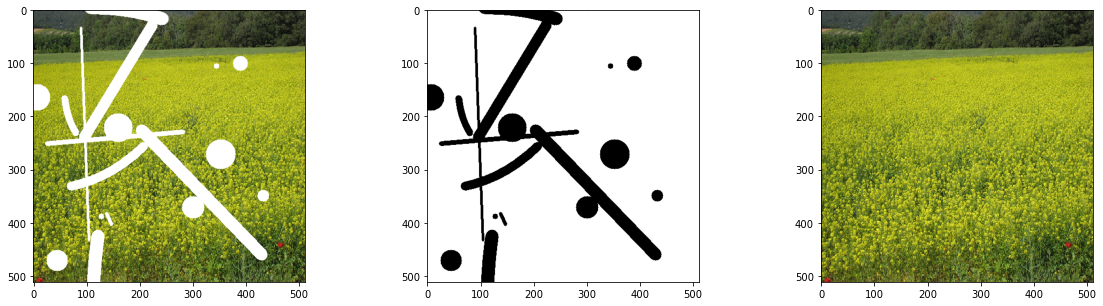

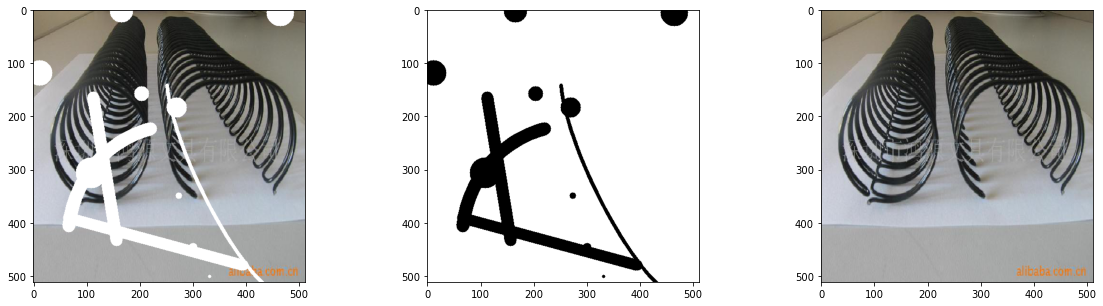

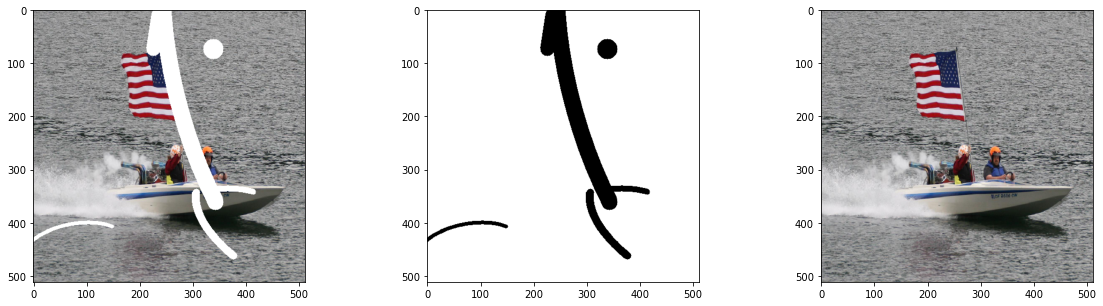

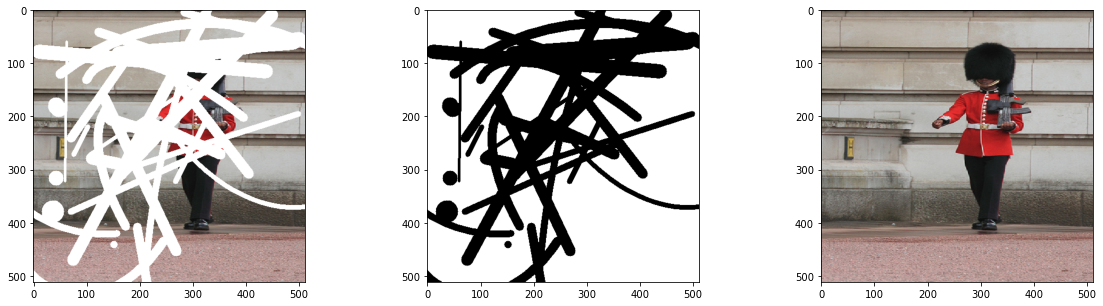

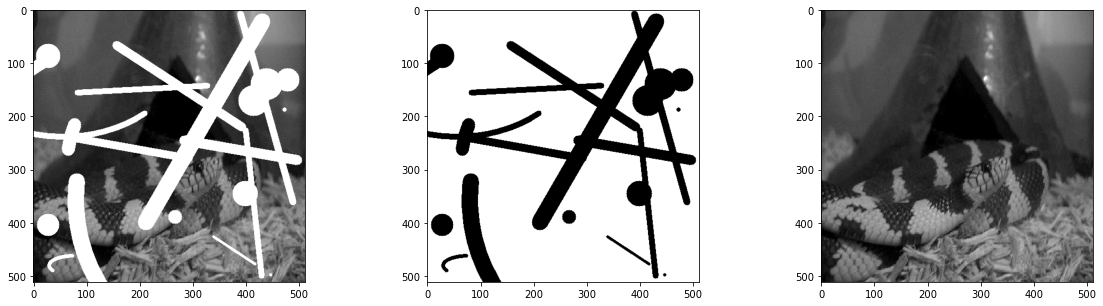

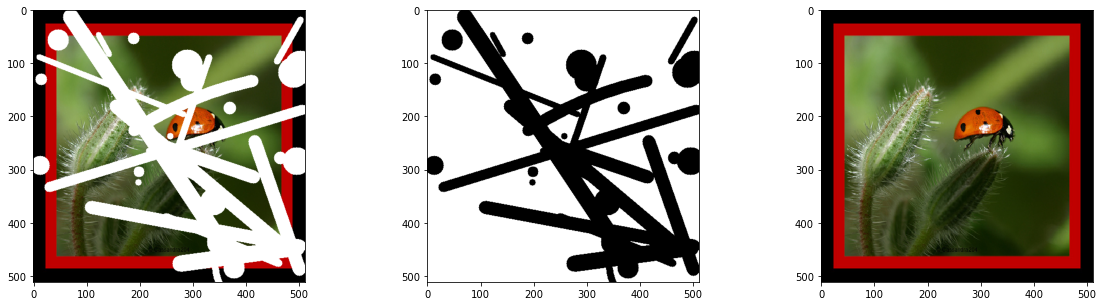

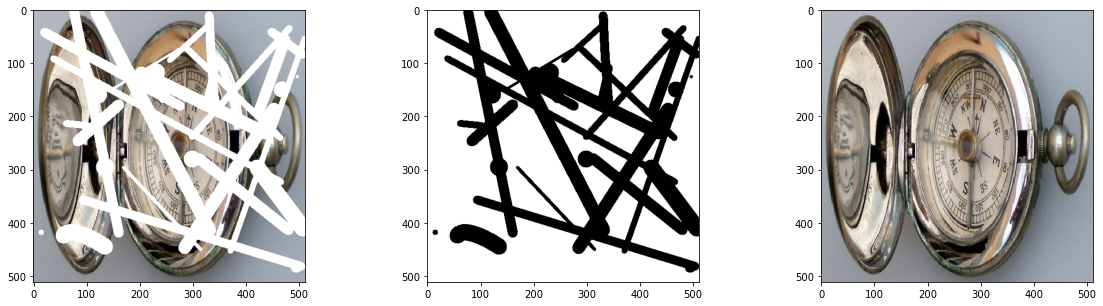

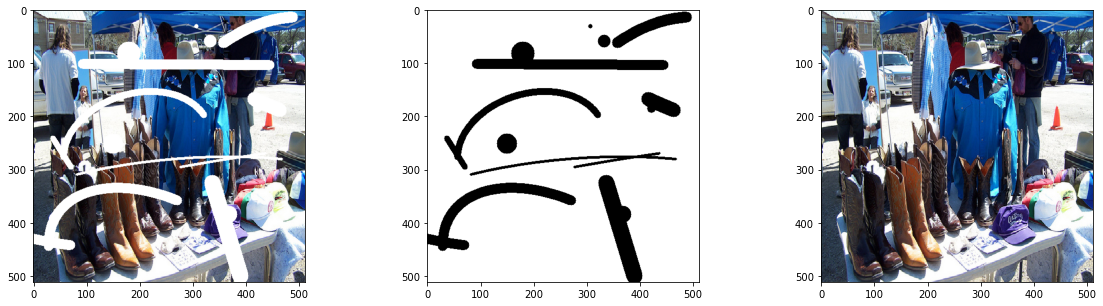

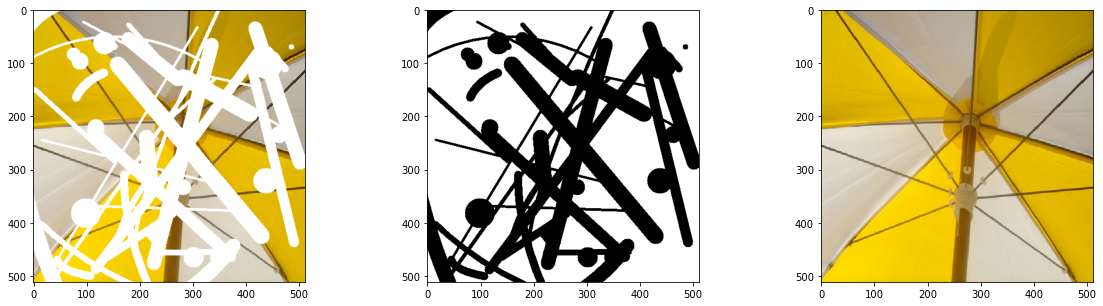

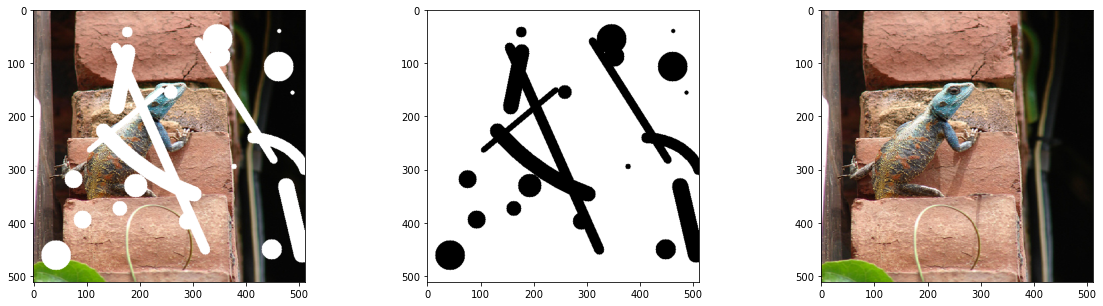

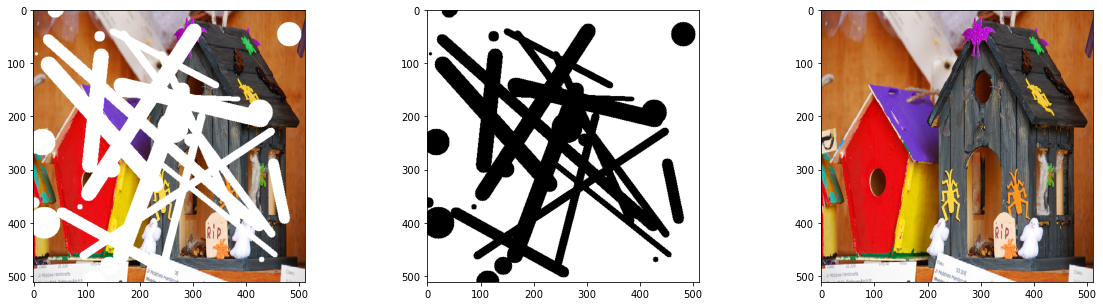

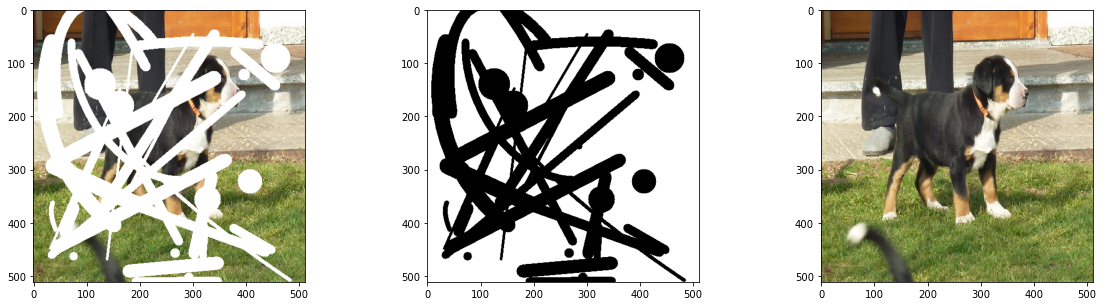

In [3]:
# Pick out an example
test_data = next(test_generator)
(masked, mask), ori = test_data

# Show side by side
for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

# Training on ImageNet

In [4]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
                
        plt.savefig(r'data/test_samples/img_{}_{}.png'.format(i, pred_time))
        plt.close()

## Phase 1 - with batch normalization

In [5]:
# Instantiate model
model = InpaintingUnet(conv_layer='pconv')
# model = InpaintingUnet(conv_layer='gconv')

Running model on 2 GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/devi

In [7]:
FOLDER = './data/logs/imagenet_phase1'

# Run training for certain amount of epochs
model.fit(
    train_generator, 
    steps_per_epoch=10000,
    validation_data=val_generator,
    validation_steps=1000,
    epochs=1,
    workers=4,
    callbacks=[
        TensorBoard(
            log_dir=FOLDER,
            write_graph=False
        ),
        ModelCheckpoint(
            os.path.join(FOLDER, 'weights.{epoch:02d}-{loss:.2f}'),
            monitor='val_PSNR', mode='max',
            save_best_only=True, 
            save_weights_only=True
        ),
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_callback(model)
        )
    ]
)

10000/10000 [==============================] - 8376s 838ms/step - l1: 0.0978 - l2: 0.2228 - l3: 1.2945 - l4: 20.5302 - l5: 13.1385 - l6: 0.0047 - loss: 35.2884 - L1_error: 0.1349 - PSNR: 15.7660 - SSIM: 0.5126 - Mask_Ratio: 0.2679 - val_PSNR: 18.3417 - val_L1_error: 0.0907 - val_SSIM: 0.5597


## Phase 2 - without batch normalization

In [ ]:
# Load weights from previous run
model = InpaintingUnet(vgg_weights='./data/logs/pytorch_vgg16.h5')
model.load(
    r"C:\Users\Mathias Felix Gruber\Documents\GitHub\PConv-Keras\data\logs\imagenet_phase1\weights.23-1.18.h5",
    train_bn=False,
    lr=0.00005
)

In [ ]:
# Run training for certain amount of epochs
model.fit_generator(
    train_generator, 
    steps_per_epoch=10000,
    validation_data=val_generator,
    validation_steps=1000,
    epochs=50,  
    verbose=0,
    callbacks=[
        TensorBoard(
            log_dir='./data/logs/imagenet_phase2',
            write_graph=False
        ),
        ModelCheckpoint(
            './data/logs/imagenet_phase2/weights.{epoch:02d}-{loss:.2f}.h5',
            monitor='val_loss', 
            save_best_only=True, 
            save_weights_only=True
        ),
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_callback(model)
        ),
        TQDMNotebookCallback()
    ]
)

## Phase 3 - Generating samples
Let us use the fine-tuned network to get some sample. We will save results in `data/test_samples` folder

In [ ]:
# Load weights from previous run
model = InpaintingUnet()
model.load(
    r"C:\Users\Mathias Felix Gruber\Documents\GitHub\PConv-Keras\data\logs\imagenet_phase2\weights.26-1.07.h5",
    train_bn=False,
    lr=0.00005
)

In [ ]:
n = 0
for (masked, mask), ori in tqdm(test_generator):
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[0].xaxis.set_major_formatter(NullFormatter())
        axes[0].yaxis.set_major_formatter(NullFormatter())
        axes[1].xaxis.set_major_formatter(NullFormatter())
        axes[1].yaxis.set_major_formatter(NullFormatter())
                
        plt.savefig(r'data/test_samples/img_{}_{}.png'.format(i, pred_time))
        plt.close()
        n += 1
        
    # Only create predictions for about 100 images
    if n > 100:
        break

# Performance Evaluation
To evaluate the performance of the network, in this notebook I'll try loading the test masks used in the original paper, and see which PSNR scores we get on imagenet 

In [ ]:
# Store data
ratios = []
psnrs = []

# Loop through test masks released with paper
test_masks = os.listdir('./data/masks/test')
for filename in tqdm(test_masks):
    
    # Load mask from paper
    filepath = os.path.join('./data/masks/test', filename)
    mask = cv2.imread(filepath) / 255
    ratios.append(mask[:,:,0].sum() / (512 * 512))
    mask = np.array([1-mask for _ in range(BATCH_SIZE)])
    
    # Pick out image from test generator
    test_data = next(val_generator)
    (_, _), ori = test_data
    
    masked = deepcopy(ori)
    masked[mask==0] = 1
    
    # Run prediction on image & mask
    pred = model.predict([ori, mask])
    
    # Calculate PSNR
    psnrs.append(-10.0 * np.log10(np.mean(np.square(pred - ori))))

In [ ]:
df = pd.DataFrame({'ratios': ratios[:2408], 'psnrs': psnrs})

means, stds = [], []
idx1 = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
idx2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

for mi, ma in zip(idx1, idx2):
    means.append(df[(df.ratios >= mi) & (df.ratios <= ma)].mean())
    stds.append(df[(df.ratios >= mi) & (df.ratios <= ma)].std())
    
pd.DataFrame(means, index=['{}-{}'.format(a, b) for a, b in zip(idx1, idx2)])